In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

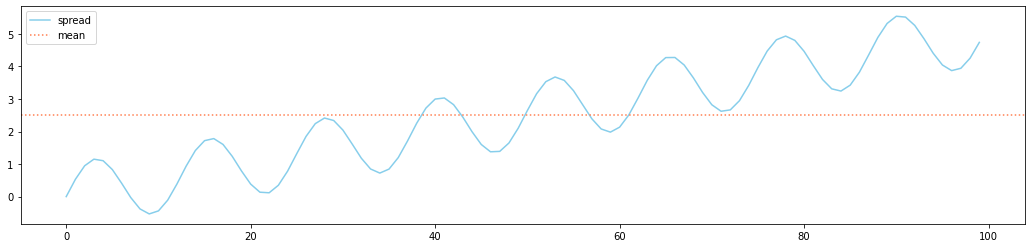

In [2]:
# generate data
x = np.linspace(0,50,100)
spread = np.sin(x)+x/10

# plot
plt.figure(figsize=(18,4))
plt.plot(spread, c='skyblue', label='spread')
plt.axhline(np.mean(spread), c='coral', linestyle='dotted', label='mean')
plt.legend()

In [3]:
def kagi(P, H):
    '''
    create kagi contrusction for process P with parameter H
    
    Args:
        P (numpy.ndarray): input time series 
        H (float): parameter of kagi construction
            
    Returns:
        tau_a (list): time moments when process P has local maximum or minimum
        tau_b (list): time moments when local maximum or minimum is recognized
    '''
    
    tau_a = []
    tau_b = []
    
    # find tau_b[0]
    for u in range(0,len(P)-1):
        if (np.max(P[0:u+1]) - np.min(P[0:u+1])) > H:
            tau_b.append(u)
            break
    
    # if not found, return empty lists
    if len(tau_b)<1:
        return tau_a, tau_b

    # find tau_a[0]
    for u in range(0,tau_b[0]):
        if abs(P[u] - P[tau_b[0]]) > H:
            tau_a.append(u)
            break
    
    # determine if tau_a[0] is min or max
    S_0 = np.sign(P[tau_a[0]] - P[tau_b[0]])

    if S_0==1: # if min
        n=1
    else: # if max
        n=0
    
    # process time series P
    finished = False
    while not finished:
        finished = True
        
        # if local minimum
        if n%2==1:
            # find tau_b
            for u in range(tau_a[-1]+1,len(P)):
                if (P[u] - np.min(P[tau_a[-1]:u+1])) > H:
                    if u > tau_b[-1]:
                        tau_b.append(u)
                        finished = False
                        break
                    else:
                        finished = True
            # find tau_a
            if not finished:
                argmin = np.argmin(P[tau_a[-1]:tau_b[-1]+1])
                tau_a.append(tau_a[-1]+argmin)
                n = n+1
        
        # if local maximum
        elif n%2==0:
            # find tau_b
            for u in range(tau_a[-1]+1,len(P)):
                if (np.max(P[tau_a[-1]:u+1]) - P[u]) > H:
                    if u > tau_b[-1]:
                        tau_b.append(u)
                        finished=False
                        break
                    else:
                        finished = True
            # find tau_a
            if not finished:
                argmax = np.argmax(P[tau_a[-1]:tau_b[-1]+1])
                tau_a.append(tau_a[-1]+argmax)
                n = n+1
                
    return tau_a, tau_b

In [4]:
H = 0.5
tau_a,tau_b = kagi(spread, H)

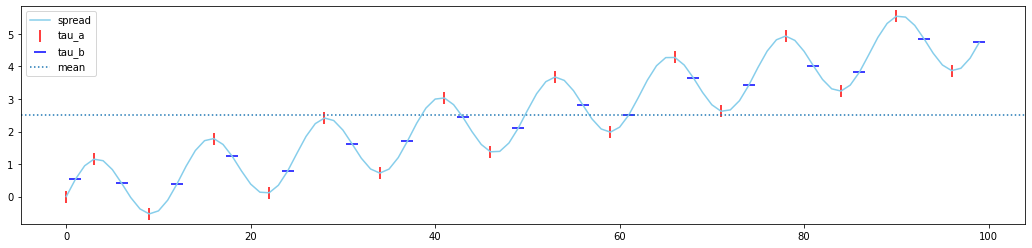

In [5]:
plt.figure(figsize=(18,4))
plt.plot(spread, c='skyblue', label='spread')
plt.scatter(tau_a, spread[tau_a], color='r', marker='|', s=150, label='tau_a')
plt.scatter(tau_b, spread[tau_b], color='b', marker='_', s=150, label='tau_b')
plt.axhline(np.mean(spread), linestyle='dotted', label='mean')
plt.legend()

In [6]:
tau_b

[1, 6, 12, 18, 24, 31, 37, 43, 49, 56, 61, 68, 74, 81, 86, 93, 99]

In [7]:
tau_a

[0, 3, 9, 16, 22, 28, 34, 41, 46, 53, 59, 66, 71, 78, 84, 90, 96]

In [8]:
spread[1]-spread[0]

0.5343566909429852

In [9]:
for i in range(1,7):
    print(f'i={i} : ', np.max(spread[0:i])-spread[i])

i=1 :  -0.5343566909429852
i=2 :  -0.4135389736700992
i=3 :  -0.2020717138024567
i=4 :  0.047241730192383535
i=5 :  0.31938954078371573
i=6 :  0.7358770372611083


In [11]:
spread[tau_b] - spread[tau_a]

array([ 0.53435669, -0.73587704,  0.91686795, -0.54567418,  0.66374221,
       -0.79710084,  0.98382104, -0.58760488,  0.72187392, -0.85492293,
        0.52879834, -0.62706622,  0.79569449, -0.90913595,  0.5799873 ,
       -0.69005036,  0.86720504])

In [12]:
def h_volatility(P, tau_a, tau_b):
    '''
    Calcuate H-volatility and H-inversion for process P with given times tau_a and tau_b
    
    Args:
        P (numpy.ndarray): input time series 
        tau_a (list): time moments when process P has local maximum or minimum
        tau_b (list): time moments when local maximum or minimum is recognized
            
    Returns:
        h_vol (float): H-volatility of order 1
        h_inv (int): H-inversion
    '''
    
    h_inv = len(tau_b)
    V = abs(np.diff(P[tau_a])).sum()
    h_vol = V / h_inv
    
    return h_vol, h_inv

In [13]:
h_volatility(spread, tau_a, tau_b)

(1.8035894948234603, 17)

# Load data

In [14]:
prices = pd.read_csv('vbr13_16.csv', index_col='Date')
prices_train = prices.loc[:'2013-12-31']
prices_test = prices.loc['2014-01-01':'2014-06-30']
log_prices = np.log(prices)
log_prices_train = log_prices.loc[:'2013-12-31']

/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [15]:
pairs_df = pd.DataFrame(columns=['H', 'H-volatility', 'H-inversion', 'Last extremum'])

In [16]:
for s1 in log_prices_train.columns:
    for s2 in log_prices_train.columns:
        if (s1!=s2) and (f'{s2}-{s1}' not in pairs_df.index):
            spread = (log_prices_train[s1] - log_prices_train[s2]).values
            H = spread.std()
            tau_a, tau_b = kagi(spread, H)
            
            if len(tau_a)<1:
                pairs_df.loc[f'{s1}-{s2}'] = -1, -1, -1, -1 # if no local min\max found
            else:              
                h_vol, h_inv = h_volatility(spread, tau_a, tau_b)
                
                if spread[tau_b[-1]] > spread[tau_a[-1]]:
                    last_extr = 'min'
                else:
                    last_extr = 'max'
                    
                pairs_df.loc[f'{s1}-{s2}'] = H, h_vol, h_inv, last_extr

In [17]:
pairs_df.sort_values(by='H-inversion', ascending=False)

,H,H-volatility,H-inversion,Last extremum
BBBY-STFC,0.041627,0.087816,41,min
NRG-SLG,0.022331,0.045875,41,max
VGR-NFBK,0.017561,0.037037,39,max
NRG-AMCX,0.035031,0.070650,39,max
KEX-OI,0.023998,0.047766,37,min
...,...,...,...,...
AIV-HTLF,-1.000000,-1.000000,-1,-1
AIV-DBI,-1.000000,-1.000000,-1,-1
AIV-DHC,-1.000000,-1.000000,-1,-1
AIV-GEO,-1.000000,-1.000000,-1,-1


In [18]:
top20_pairs = pairs_df.sort_values(by='H-inversion', ascending=False).index[:20]

In [20]:
top20_df = pairs_df.loc[top20_pairs]
top20_df[top20_df['H-volatility'] > 2*top20_df['H']]

,H,H-volatility,H-inversion,Last extremum
BBBY-STFC,0.041627,0.087816,41,min
NRG-SLG,0.022331,0.045875,41,max
VGR-NFBK,0.017561,0.037037,39,max
NRG-AMCX,0.035031,0.070650,39,max
BKH-STFC,0.039427,0.081558,36,max
CBSH-STFC,0.043280,0.089116,34,max


# Strategy 1. 5 Pairs

In [21]:
def parse_pair(pair):
    s1 = pair[:pair.find('-')]
    s2 = pair[pair.find('-')+1:]
    return s1,s2

In [22]:
selected_pairs = []
selected_stocks = []

for pair in pairs_df.sort_values(by='H-inversion', ascending=False).index:
    s1,s2 = parse_pair(pair)
    if (s1 not in selected_stocks) and (s2 not in selected_stocks):
        selected_pairs.append(pair)
        selected_stocks.append(s1)
        selected_stocks.append(s2)
    if len(selected_pairs)==5:
        break

In [23]:
selected_pairs

['BBBY-STFC', 'NRG-SLG', 'VGR-NFBK', 'KEX-OI', 'AFG-SON']

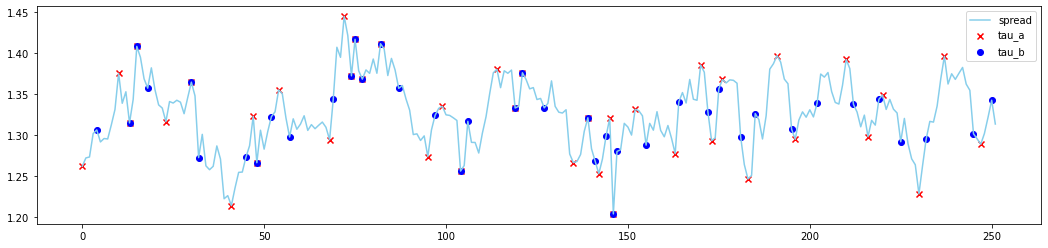

In [24]:
s1,s2 = parse_pair(selected_pairs[0])
spread = log_prices_train[s1]-log_prices_train[s2]
tau_a, tau_b = kagi(spread.values, spread.std())

plt.figure(figsize=(18,4))
plt.plot(spread.values, c='skyblue', label='spread')
plt.scatter(tau_a, spread[tau_a], color='r', marker='x', label='tau_a')
plt.scatter(tau_b, spread[tau_b], color='b', marker='o', label='tau_b')
plt.legend()

In [25]:
returns = prices.pct_change()
log_prices_test = log_prices.loc['2014-01-01':'2014-06-30']
returns_test = returns.loc['2014-01-01':'2014-06-30']

In [26]:
positions = pd.DataFrame(index=returns_test.index, columns=selected_stocks)

for t in log_prices_test.index:
    log_prices_tmp = log_prices.loc[:t]
    log_prices_tmp = log_prices_tmp.iloc[-252:]
    
    for pair in selected_pairs:
        s1,s2 = parse_pair(pair)
        spread = (log_prices_tmp[s1] - log_prices_tmp[s2]).values
        H = pairs_df.loc[pair, 'H']
        h_vol = pairs_df.loc[pair, 'H-volatility']
        tau_a,tau_b = kagi(spread, H)
        
        if tau_b[-1] == (len(spread)-1): # new local extremum detected
            if spread[tau_a[-1]] > spread[tau_b[-1]]: # spread moves down
                if h_vol > 2*H: # trend following
                    positions.loc[t, [s1,s2]] = [-1,1]
                else: # contrarian
                    positions.loc[t, [s1,s2]] = [1,-1]
            else: # spread moves up
                if h_vol > 2*H: # trend following
                    positions.loc[t, [s1,s2]] = [1,-1]
                else: # contrarian
                    positions.loc[t, [s1,s2]] = [-1,1]

In [27]:
positions.fillna(method='ffill', inplace=True)
positions

,BBBY,STFC,NRG,SLG,VGR,NFBK,KEX,OI,AFG,SON
Date,,,,,,,,,,
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,1,-1,1,-1
2014-01-03,NaN,NaN,NaN,NaN,1.0,-1.0,1,-1,-1,1
2014-01-06,NaN,NaN,NaN,NaN,1.0,-1.0,1,-1,-1,1
2014-01-07,-1.0,1.0,NaN,NaN,1.0,-1.0,1,-1,-1,1
2014-01-08,-1.0,1.0,NaN,NaN,1.0,-1.0,1,-1,1,-1
...,...,...,...,...,...,...,...,...,...,...
2014-06-24,-1.0,1.0,1.0,-1.0,-1.0,1.0,1,-1,1,-1
2014-06-25,-1.0,1.0,1.0,-1.0,-1.0,1.0,1,-1,1,-1
2014-06-26,-1.0,1.0,1.0,-1.0,-1.0,1.0,1,-1,1,-1


In [28]:
# add positions at the beginning of the trading period
for pair in selected_pairs:
    s1,s2 = parse_pair(pair)
    H = pairs_df.loc[pair, 'H']
    h_vol = pairs_df.loc[pair, 'H-volatility']
    last_extr = pairs_df.loc[pair, 'Last extremum']
    if h_vol > 2*H: # trend following
        if last_extr=='min':
            # short position
            positions[s1].fillna(-1, inplace=True) 
            positions[s2].fillna(1, inplace=True)
        else:
            # long position
            positions[s1].fillna(1, inplace=True) 
            positions[s2].fillna(-1, inplace=True)
    else: # contrarian
        if last_extr=='min':
            # long position
            positions[s1].fillna(1, inplace=True) 
            positions[s2].fillna(-1, inplace=True)
        else:
            # short position
            positions[s1].fillna(-1, inplace=True) 
            positions[s2].fillna(1, inplace=True)

In [29]:
positions

,BBBY,STFC,NRG,SLG,VGR,NFBK,KEX,OI,AFG,SON
Date,,,,,,,,,,
2014-01-02,-1.0,1.0,1.0,-1.0,1.0,-1.0,1,-1,1,-1
2014-01-03,-1.0,1.0,1.0,-1.0,1.0,-1.0,1,-1,-1,1
2014-01-06,-1.0,1.0,1.0,-1.0,1.0,-1.0,1,-1,-1,1
2014-01-07,-1.0,1.0,1.0,-1.0,1.0,-1.0,1,-1,-1,1
2014-01-08,-1.0,1.0,1.0,-1.0,1.0,-1.0,1,-1,1,-1
...,...,...,...,...,...,...,...,...,...,...
2014-06-24,-1.0,1.0,1.0,-1.0,-1.0,1.0,1,-1,1,-1
2014-06-25,-1.0,1.0,1.0,-1.0,-1.0,1.0,1,-1,1,-1
2014-06-26,-1.0,1.0,1.0,-1.0,-1.0,1.0,1,-1,1,-1


In [30]:
(positions.shift() * returns_test[selected_stocks] + 1).cumprod()

,BBBY,STFC,NRG,SLG,VGR,NFBK,KEX,OI,AFG,SON
Date,,,,,,,,,,
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,0.994377,1.013359,1.002799,0.990976,0.999389,1.009931,1.000929,1.018857,1.002833,1.014173
2014-01-06,1.010810,1.009542,1.004549,0.996315,0.994499,1.006035,0.986474,1.008628,1.008499,1.012443
2014-01-07,1.010044,1.025286,1.002449,0.987357,1.003668,0.995209,0.999484,1.003758,1.000799,1.027270
2014-01-08,1.004051,1.030057,0.995452,0.988311,0.987775,1.004291,1.001859,1.005460,1.000975,1.053959
...,...,...,...,...,...,...,...,...,...,...
2014-06-24,1.378901,0.700206,0.967932,0.862475,0.956494,0.994111,1.043236,0.866748,0.934547,1.106944
2014-06-25,1.368213,0.710301,0.970039,0.867152,0.962498,0.995637,1.057687,0.862197,0.938958,1.103618
2014-06-26,1.466951,0.709995,0.965825,0.871584,0.956886,0.992585,1.058967,0.859695,0.933760,1.106416


In [31]:
ret = (positions.shift() * returns_test[selected_stocks]).sum(axis=1) / 5 * 2
cumret = np.nancumprod(ret+1)

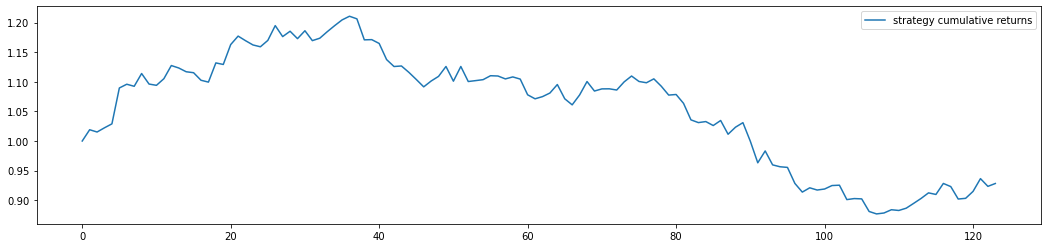

In [33]:
plt.figure(figsize=(18,4))
plt.plot(cumret, label='strategy cumulative returns')
plt.legend()

In [34]:
def calculate_metrics(cumret):
    '''
    calculate performance metrics from cumulative returns
    '''
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(252/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)
    
    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)
    
    return total_return, apr, sharpe, maxDD, maxDDD

In [35]:
calculate_metrics(cumret)

(-0.07175642183100006,
 -0.14043100109676798,
 -0.5552670125133877,
 -0.2757572332255326,
 87.0)

In [36]:
columns = ['Total return', 'APR', 'Sharpe ratio', 'Max Drawdown', 'Max Drawdown Duration']

performance_df = pd.DataFrame(columns=columns)

In [37]:
performance_df.loc['Strategy 1. 5 pairs'] = calculate_metrics(cumret)

In [38]:
performance_df

,Total return,APR,Sharpe ratio,Max Drawdown,Max Drawdown Duration
Strategy 1. 5 pairs,-0.071756,-0.140431,-0.555267,-0.275757,87.0


# Strategy 2. 5 pairs

update spread parameters each day

In [51]:
positions = pd.DataFrame(index=returns_test.index, columns=selected_stocks)

for t in log_prices_test.index:
    log_prices_tmp = log_prices.loc[:t]
    log_prices_tmp = log_prices_tmp.iloc[-252:]
    
    for pair in selected_pairs:
        s1,s2 = parse_pair(pair)
        spread = (log_prices_tmp[s1] - log_prices_tmp[s2]).values
        #H = pairs_df.loc[pair, 'H']
        #h_vol = pairs_df.loc[pair, 'H-volatility']
        H = spread.std()
        tau_a,tau_b = kagi(spread, H)
        h_vol, h_inv = h_volatility(spread, tau_a, tau_b)
        
        if tau_b[-1] == (len(spread)-1):
            if spread[tau_a[-1]] > spread[tau_b[-1]]: # spread moves down
                if h_vol > 2*H: # trend following
                    positions.loc[t, [s1,s2]] = [-1,1]
                else: # contrarian
                    positions.loc[t, [s1,s2]] = [1,-1]
            else: # spread moves up
                if h_vol > 2*H: # trend following
                    positions.loc[t, [s1,s2]] = [1,-1]
                else: # contrarian
                    positions.loc[t, [s1,s2]] = [-1,1]

In [52]:
positions.fillna(method='ffill', inplace=True)
positions.fillna(0, inplace=True)
positions

,BBBY,STFC,NRG,SLG,VGR,NFBK,KEX,OI,AFG,SON
Date,,,,,,,,,,
2014-01-02,0.0,0.0,0.0,0.0,0.0,0.0,1,-1,1,-1
2014-01-03,0.0,0.0,0.0,0.0,1.0,-1.0,1,-1,-1,1
2014-01-06,0.0,0.0,0.0,0.0,1.0,-1.0,1,-1,-1,1
2014-01-07,-1.0,1.0,0.0,0.0,1.0,-1.0,1,-1,-1,1
2014-01-08,-1.0,1.0,0.0,0.0,1.0,-1.0,1,-1,1,-1
...,...,...,...,...,...,...,...,...,...,...
2014-06-24,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1,1,-1,1
2014-06-25,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1,1,-1,1
2014-06-26,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1,1,-1,1


In [53]:
(positions.shift() * returns_test[selected_stocks] + 1).cumprod()

,BBBY,STFC,NRG,SLG,VGR,NFBK,KEX,OI,AFG,SON
Date,,,,,,,,,,
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000929,1.018857,1.002833,1.014173
2014-01-06,1.000000,1.000000,1.000000,1.000000,0.995107,0.996142,0.986474,1.008628,1.008499,1.012443
2014-01-07,1.000000,1.000000,1.000000,1.000000,1.004281,0.985423,0.999484,1.003758,1.000799,1.027270
2014-01-08,0.994066,1.004653,1.000000,1.000000,0.988379,0.994415,1.001859,1.005460,1.000975,1.053959
...,...,...,...,...,...,...,...,...,...,...
2014-06-24,1.388638,0.981649,1.133489,0.911256,1.316027,0.975886,1.119378,0.880361,0.962084,1.122934
2014-06-25,1.377874,0.995801,1.131022,0.906315,1.307766,0.974388,1.103872,0.884984,0.957543,1.126308
2014-06-26,1.477309,0.995372,1.135935,0.901683,1.315392,0.977374,1.102535,0.887552,0.962844,1.123453


In [54]:
ret = (positions.shift() * returns_test[selected_stocks]).sum(axis=1) / 5 * 2
cumret = np.nancumprod(ret+1)

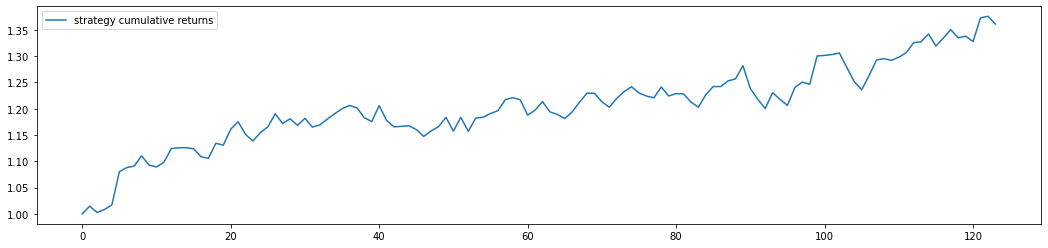

In [55]:
plt.figure(figsize=(18,4))
plt.plot(cumret, label='strategy cumulative returns')
plt.legend()

In [43]:
performance_df.loc['Strategy 2. 5 pairs'] = calculate_metrics(cumret)

In [44]:
performance_df

,Total return,APR,Sharpe ratio,Max Drawdown,Max Drawdown Duration
Strategy 1. 5 pairs,-0.071756,-0.140431,-0.555267,-0.275757,87.0
Strategy 2. 5 pairs,0.360971,0.870749,2.800469,-0.063386,20.0


# Strategy 1. 20 pairs

In [56]:
selected_pairs = []
selected_stocks = []

for pair in pairs_df.sort_values(by='H-inversion', ascending=False).index:
    s1,s2 = parse_pair(pair)
    if (s1 not in selected_stocks) and (s2 not in selected_stocks):
        selected_pairs.append(pair)
        selected_stocks.append(s1)
        selected_stocks.append(s2)
    if len(selected_pairs)==20:
        break

In [57]:
positions = pd.DataFrame(index=returns_test.index, columns=selected_stocks)

for t in log_prices_test.index:
    log_prices_tmp = log_prices.loc[:t]
    log_prices_tmp = log_prices_tmp.iloc[-252:]
    
    for pair in selected_pairs:
        s1,s2 = parse_pair(pair)
        spread = (log_prices_tmp[s1] - log_prices_tmp[s2]).values
        H = pairs_df.loc[pair, 'H']
        h_vol = pairs_df.loc[pair, 'H-volatility']
        tau_a,tau_b = kagi(spread, H)
        
        if tau_b[-1] == (len(spread)-1):
            if spread[tau_a[-1]] > spread[tau_b[-1]]: # spread moves down
                if h_vol > 2*H: # trend following
                    positions.loc[t, [s1,s2]] = [-1,1]
                else: # contrarian
                    positions.loc[t, [s1,s2]] = [1,-1]
            else: # spread moves up
                if h_vol > 2*H: # trend following
                    positions.loc[t, [s1,s2]] = [1,-1]
                else: # contrarian
                    positions.loc[t, [s1,s2]] = [-1,1]

In [58]:
positions.fillna(method='ffill', inplace=True)
for pair in selected_pairs:
    s1,s2 = parse_pair(pair)
    H = pairs_df.loc[pair, 'H']
    h_vol = pairs_df.loc[pair, 'H-volatility']
    last_extr = pairs_df.loc[pair, 'Last extremum']
    if h_vol > 2*H: # trend following
        if last_extr=='min':
            # short position
            positions[s1].fillna(-1, inplace=True) 
            positions[s2].fillna(1, inplace=True)
        else:
            # long position
            positions[s1].fillna(1, inplace=True) 
            positions[s2].fillna(-1, inplace=True)
    else: # contrarian
        if last_extr=='min':
            # long position
            positions[s1].fillna(1, inplace=True) 
            positions[s2].fillna(-1, inplace=True)
        else:
            # short position
            positions[s1].fillna(-1, inplace=True) 
            positions[s2].fillna(1, inplace=True)

In [59]:
(positions.shift() * returns_test[selected_stocks] + 1).cumprod()

,BBBY,STFC,NRG,SLG,VGR,NFBK,KEX,OI,AFG,SON,...,MHK,NFG,STLD,LAZ,KSS,HNI,HP,ODP,CIT,INDB
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,0.994377,1.013359,1.002799,0.990976,0.999389,1.009931,1.000929,1.018857,1.002833,1.014173,...,1.002280,1.000995,0.997916,0.990396,0.997719,0.985920,0.990274,0.986867,1.000967,0.999479
2014-01-06,1.010810,1.009542,1.004549,0.996315,0.994499,1.006035,0.986474,1.008628,1.008499,1.012443,...,0.988130,1.007545,0.982812,0.992368,0.983330,1.000116,1.003390,0.908068,0.995939,1.011700
2014-01-07,1.010044,1.025286,1.002449,0.987357,1.003668,0.995209,0.999484,1.003758,1.000799,1.027270,...,0.977064,0.984606,0.989062,0.987088,0.984383,0.986809,1.023348,0.909944,1.004834,1.005305
2014-01-08,1.004051,1.030057,0.995452,0.988311,0.987775,1.004291,1.001859,1.005460,1.000975,1.053959,...,0.986520,0.989707,1.001042,0.985781,0.968240,0.998496,1.034000,0.887337,1.008314,1.008725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-06-24,1.378901,0.700206,0.967932,0.862475,0.956494,0.994111,1.043236,0.866748,0.934547,1.106944,...,1.128974,1.048912,1.000203,0.893378,0.787470,0.875678,1.122265,0.878611,1.229887,0.921389
2014-06-25,1.368213,0.710301,0.970039,0.867152,0.962498,0.995637,1.057687,0.862197,0.938958,1.103618,...,1.136558,1.034590,0.988837,0.902245,0.792069,0.886005,1.145767,0.878611,1.225257,0.927919
2014-06-26,1.466951,0.709995,0.965825,0.871584,0.956886,0.992585,1.058967,0.859695,0.933760,1.106416,...,1.131974,1.031291,0.983525,0.874251,0.788317,0.869942,1.158523,0.864286,1.226338,0.928162


In [60]:
ret = (positions.shift() * returns_test[selected_stocks]).sum(axis=1) / 20 * 2
cumret = np.nancumprod(ret+1)

In [61]:
performance_df.loc['Strategy 1. 20 pairs'] = calculate_metrics(cumret)

In [62]:
performance_df

,Total return,APR,Sharpe ratio,Max Drawdown,Max Drawdown Duration
Strategy 1. 5 pairs,-0.071756,-0.140431,-0.555267,-0.275757,87.0
Strategy 2. 5 pairs,0.360971,0.870749,2.800469,-0.063386,20.0
Strategy 1. 20 pairs,0.054346,0.113546,0.931370,-0.083614,49.0


# Strategy 2. 20 pairs

In [63]:
positions = pd.DataFrame(index=returns_test.index, columns=selected_stocks)

for t in log_prices_test.index:
    log_prices_tmp = log_prices.loc[:t]
    log_prices_tmp = log_prices_tmp.iloc[-252:]
    
    for pair in selected_pairs:
        s1,s2 = parse_pair(pair)
        spread = (log_prices_tmp[s1] - log_prices_tmp[s2]).values
        #H = pairs_df.loc[pair, 'H']
        #h_vol = pairs_df.loc[pair, 'H-volatility']
        H = spread.std()
        tau_a,tau_b = kagi(spread, H)
        h_vol, h_inv = h_volatility(spread, tau_a, tau_b)
        
        if tau_b[-1] == (len(spread)-1):
            if spread[tau_a[-1]] > spread[tau_b[-1]]: # spread moves down
                if h_vol > 2*H: # trend following
                    positions.loc[t, [s1,s2]] = [-1,1]
                else: # contrarian
                    positions.loc[t, [s1,s2]] = [1,-1]
            else: # spread moves up
                if h_vol > 2*H: # trend following
                    positions.loc[t, [s1,s2]] = [1,-1]
                else: # contrarian
                    positions.loc[t, [s1,s2]] = [-1,1]

In [64]:
positions.fillna(method='ffill', inplace=True)
positions.fillna(0, inplace=True)
positions

,BBBY,STFC,NRG,SLG,VGR,NFBK,KEX,OI,AFG,SON,...,MHK,NFG,STLD,LAZ,KSS,HNI,HP,ODP,CIT,INDB
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,0.0,0.0,0.0,0.0,0.0,0.0,1,-1,1,-1,...,0.0,0.0,0.0,0.0,1,-1,-1,1,1,-1
2014-01-03,0.0,0.0,0.0,0.0,1.0,-1.0,1,-1,-1,1,...,0.0,0.0,0.0,0.0,1,-1,-1,1,1,-1
2014-01-06,0.0,0.0,0.0,0.0,1.0,-1.0,1,-1,-1,1,...,0.0,0.0,1.0,-1.0,1,-1,1,-1,1,-1
2014-01-07,-1.0,1.0,0.0,0.0,1.0,-1.0,1,-1,-1,1,...,1.0,-1.0,1.0,-1.0,1,-1,1,-1,1,-1
2014-01-08,-1.0,1.0,0.0,0.0,1.0,-1.0,1,-1,1,-1,...,1.0,-1.0,1.0,-1.0,1,-1,1,-1,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-06-24,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1,1,-1,1,...,1.0,-1.0,1.0,-1.0,1,-1,1,-1,1,-1
2014-06-25,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1,1,-1,1,...,1.0,-1.0,1.0,-1.0,1,-1,1,-1,1,-1
2014-06-26,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1,1,-1,1,...,1.0,-1.0,1.0,-1.0,1,-1,1,-1,1,-1


In [65]:
(positions.shift() * returns_test[selected_stocks] + 1).cumprod()

,BBBY,STFC,NRG,SLG,VGR,NFBK,KEX,OI,AFG,SON,...,MHK,NFG,STLD,LAZ,KSS,HNI,HP,ODP,CIT,INDB
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000929,1.018857,1.002833,1.014173,...,1.000000,1.000000,1.000000,1.000000,0.997719,0.985920,0.990274,0.986867,1.000967,0.999479
2014-01-06,1.000000,1.000000,1.000000,1.000000,0.995107,0.996142,0.986474,1.008628,1.008499,1.012443,...,1.000000,1.000000,1.000000,1.000000,0.983330,1.000116,1.003390,0.908068,0.995939,1.011700
2014-01-07,1.000000,1.000000,1.000000,1.000000,1.004281,0.985423,0.999484,1.003758,1.000799,1.027270,...,1.000000,1.000000,1.006359,0.994680,0.984383,0.986809,1.023348,0.909944,1.004834,1.005305
2014-01-08,0.994066,1.004653,1.000000,1.000000,0.988379,0.994415,1.001859,1.005460,1.000975,1.053959,...,1.009678,1.005180,1.018548,0.993363,0.968240,0.998496,1.034000,0.887337,1.008314,1.008725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-06-24,1.388638,0.981649,1.133489,0.911256,1.316027,0.975886,1.119378,0.880361,0.962084,1.122934,...,1.267359,1.058574,0.894855,0.976961,1.296634,0.853529,1.385938,0.730709,0.830126,1.098632
2014-06-25,1.377874,0.995801,1.131022,0.906315,1.307766,0.974388,1.103872,0.884984,0.957543,1.126308,...,1.275873,1.044121,0.905024,0.967264,1.289061,0.843463,1.414962,0.730709,0.833251,1.090846
2014-06-26,1.477309,0.995372,1.135935,0.901683,1.315392,0.977374,1.102535,0.887552,0.962844,1.123453,...,1.270727,1.040791,0.909886,0.997276,1.295168,0.858755,1.430714,0.718795,0.832516,1.090561


In [66]:
ret = (positions.shift() * returns_test[selected_stocks]).sum(axis=1) / 20 * 2
cumret = np.nancumprod(ret+1)

In [67]:
performance_df.loc['Strategy 2. 20 pairs'] = calculate_metrics(cumret)

In [68]:
performance_df

,Total return,APR,Sharpe ratio,Max Drawdown,Max Drawdown Duration
Strategy 1. 5 pairs,-0.071756,-0.140431,-0.555267,-0.275757,87.0
Strategy 2. 5 pairs,0.360971,0.870749,2.800469,-0.063386,20.0
Strategy 1. 20 pairs,0.054346,0.113546,0.931370,-0.083614,49.0
Strategy 2. 20 pairs,0.148914,0.325928,2.434790,-0.077479,49.0
